In [ ]:
%load_ext rich
from datasets import load_dataset

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

sns.set_context("notebook")
sns.set_palette("colorblind")

ds = load_dataset("mstz/heloc")

## HELOC

The HELOC dataset from FICO. Each entry in the dataset is a line of credit, typically offered by a bank as a percentage of home equity (the difference between the current market value of a home and its purchase price). The customers in this dataset have requested a credit line in the range of $5,000 - $150,000. The fundamental task is to use the information about the applicant in their credit report to predict whether they will repay their HELOC account within 2 years.

In [2]:
df = pd.DataFrame(ds["train"])
est_risk = df.pop("estimate_of_risk")

In [3]:
y = np.array(df.pop("is_at_risk"))
df.head()

,months_since_first_trade,months_since_last_trade,average_duration_of_resolution,number_of_satisfactory_trades,nr_trades_insolvent_for_over_60_days,nr_trades_insolvent_for_over_90_days,percentage_of_legal_trades,months_since_last_illegal_trade,maximum_illegal_trades_over_last_year,maximum_illegal_trades,...,percentage_of_installment_trades,months_since_last_inquiry_not_recent,nr_inquiries_in_last_6_months,nr_inquiries_in_last_6_months_not_recent,net_fraction_of_revolving_burden,net_fraction_of_installment_burden,nr_revolving_trades_with_balance,nr_installment_trades_with_balance,nr_banks_with_high_ratio,percentage_trades_with_balance
0,144,4,84,20,3,0,83,2,3,5,...,43,0,0,0,33,-8,8,1,1,69
1,58,15,41,2,4,4,100,-7,0,8,...,67,0,0,0,0,-8,0,-8,-8,0
2,66,5,24,9,0,0,100,-7,7,8,...,44,0,4,4,53,66,4,2,1,86
3,169,1,73,28,1,1,93,76,6,6,...,57,0,5,4,72,83,6,4,3,91
4,333,27,132,12,0,0,100,-7,7,8,...,25,0,1,1,51,89,3,1,0,80


In [4]:
y.sum()/len(y)

0.5219428243617936

## Some simple feature engineering and cleaning

The data is very clean already...

In [5]:
df[df<0] = 0
# Count missing values
df.isna().sum(axis=0)


months_since_first_trade                    0
months_since_last_trade                     0
average_duration_of_resolution              0
number_of_satisfactory_trades               0
nr_trades_insolvent_for_over_60_days        0
nr_trades_insolvent_for_over_90_days        0
percentage_of_legal_trades                  0
months_since_last_illegal_trade             0
maximum_illegal_trades_over_last_year       0
maximum_illegal_trades                      0
nr_total_trades                             0
nr_trades_initiated_in_last_year            0
percentage_of_installment_trades            0
months_since_last_inquiry_not_recent        0
nr_inquiries_in_last_6_months               0
nr_inquiries_in_last_6_months_not_recent    0
net_fraction_of_revolving_burden            0
net_fraction_of_installment_burden          0
nr_revolving_trades_with_balance            0
nr_installment_trades_with_balance          0
nr_banks_with_high_ratio                    0
percentage_trades_with_balance   

In [6]:
df.max(axis=0)


months_since_first_trade                    803
months_since_last_trade                     383
average_duration_of_resolution              383
number_of_satisfactory_trades                79
nr_trades_insolvent_for_over_60_days         19
nr_trades_insolvent_for_over_90_days         19
percentage_of_legal_trades                  100
months_since_last_illegal_trade              83
maximum_illegal_trades_over_last_year         9
maximum_illegal_trades                        8
nr_total_trades                             104
nr_trades_initiated_in_last_year             19
percentage_of_installment_trades            100
months_since_last_inquiry_not_recent         24
nr_inquiries_in_last_6_months                66
nr_inquiries_in_last_6_months_not_recent     66
net_fraction_of_revolving_burden            232
net_fraction_of_installment_burden          471
nr_revolving_trades_with_balance             32
nr_installment_trades_with_balance           23
nr_banks_with_high_ratio               

In [7]:
np.isfinite(df).sum(axis=0) / df.shape[0]


months_since_first_trade                    1.0
months_since_last_trade                     1.0
average_duration_of_resolution              1.0
number_of_satisfactory_trades               1.0
nr_trades_insolvent_for_over_60_days        1.0
nr_trades_insolvent_for_over_90_days        1.0
percentage_of_legal_trades                  1.0
months_since_last_illegal_trade             1.0
maximum_illegal_trades_over_last_year       1.0
maximum_illegal_trades                      1.0
nr_total_trades                             1.0
nr_trades_initiated_in_last_year            1.0
percentage_of_installment_trades            1.0
months_since_last_inquiry_not_recent        1.0
nr_inquiries_in_last_6_months               1.0
nr_inquiries_in_last_6_months_not_recent    1.0
net_fraction_of_revolving_burden            1.0
net_fraction_of_installment_burden          1.0
nr_revolving_trades_with_balance            1.0
nr_installment_trades_with_balance          1.0
nr_banks_with_high_ratio               

In [8]:
df["ratio_trades_last_year_to_total"]    = np.log10(0.01 + (df["nr_trades_initiated_in_last_year"] / (1 + df["nr_total_trades"])))
df["ratio_revolving_trades_to_total"]    = np.log10(0.01 + (df["nr_revolving_trades_with_balance"] / (1 + df["nr_total_trades"])))
df["ratio_installment_trades_to_total"]  = np.log10(0.01 + (df["nr_installment_trades_with_balance"] / (1 + df["nr_total_trades"])))
df["ratio_satisfactory_trades_to_total"] = np.log10(0.01 + (df["number_of_satisfactory_trades"] / (1 + df["nr_total_trades"])))
df["ratio_installment_to_revolving"]     = np.log10(0.01 + (df["net_fraction_of_installment_burden"] / (1 + df["net_fraction_of_revolving_burden"])))


In [9]:
@interact(feature=df.columns)
def feature_histogram(feature):
    sns.histplot(df[feature], kde=True, bins=30)
    plt.show()

interactive(children=(Dropdown(description='feature', options=('months_since_first_trade', 'months_since_last_…

# Baseline models

0.7730


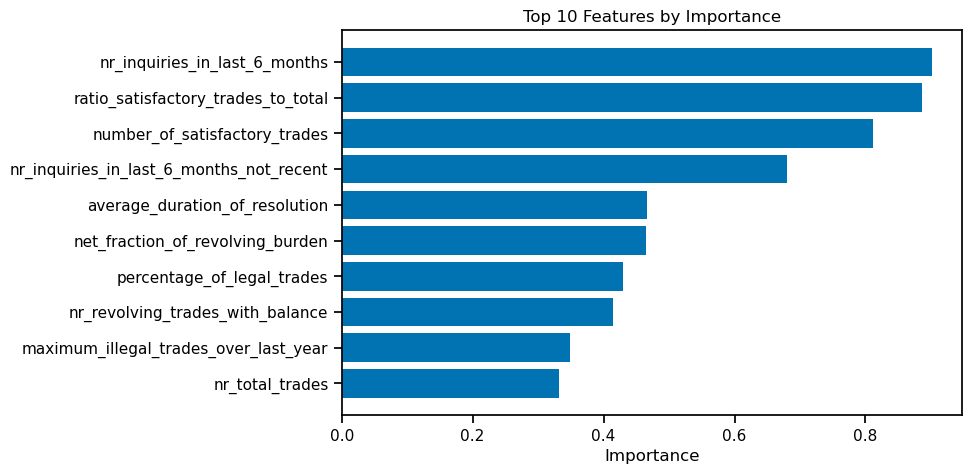

In [10]:
lm = LogisticRegression()
X = StandardScaler().fit_transform(df)
print(f"{cross_validate(lm, X, y, cv=5, scoring="roc_auc")["test_score"].mean():.4f}")
lm = lm.fit(X, y)
y_pred = lm.predict_proba(X)[:, 1]

importances = np.abs(lm.coef_[0])
indices = np.argsort(importances)[-10:][::-1]
top_features = df.columns[indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features, importances[indices])
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()
plt.show()
plt.close()

In [11]:
ebm = ExplainableBoostingClassifier(interactions=10, greedy_ratio=0)
print(f"{cross_validate(ebm, df, y, cv=5, scoring="roc_auc", n_jobs=5)["test_score"].mean():.4f}")
ebm.fit(df, y)
ebm_global = ebm.explain_global()
show(ebm_global)

0.7718


<!-- http://127.0.0.1:7001/134475342952592/ -->

In [ ]:
df.to_parquet("heloc.parquet")
y.tofile("heloc_y.npy")